In [1]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains
from pyspark.sql.functions import sum,avg,max
from pyspark.sql.functions import udf


In [2]:
# Get spark session
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

In [3]:
df = spark.read.csv("crawled_product_v3.csv")
df.printSchema()
df.show(10)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)

+---------+--------------------+------------------+-------------------+--------+------------+--------------+------------+-------------------+--------------------+-------------+----------+--------+
|      _c0|                 _c1|               _c2|                _c3|     _c4|         _c5|           _c6|         _c7|                _c8|                 _c9|         _c10|      _c11|    _c12|
+---------+--------------------+------------------+-------------------+--------+------------+--------------+------------+-------------------+-

In [4]:
# create schema
schema = StructType() \
      .add("ID",IntegerType(),True) \
      .add("ProductName",StringType(),True) \
      .add("PriceAfterDiscount",DoubleType(),True) \
      .add("PriceBeforeDiscount",DoubleType(),True) \
      .add("Discount",DoubleType(),True) \
      .add("DiscountRate",DoubleType(),True) \
      .add("RatingAverage",DoubleType(),True) \
      .add("ReviewCount",IntegerType(),True) \
      .add("Date",StringType(),True) \
      .add("Url",StringType(),True) \
      .add("QuantitySold",IntegerType(),True) \
      .add("Category",StringType(),True) \
      .add("Location",StringType(),True)

In [5]:
#Data from Shopee, sendo, lazada
spark.read.csv("ProductDetail.csv").show(1, False)

+---+-----------+-------------------+------------------+--------+----+------+--------+----+--------+----+--------+
|_c0|_c1        |_c2                |_c3               |_c4     |_c5 |_c6   |_c7     |_c8 |_c9     |_c10|_c11    |
+---+-----------+-------------------+------------------+--------+----+------+--------+----+--------+----+--------+
|url|productname|pricebeforediscount|priceafterdiscount|position|sold|rating|category|date|feedback|id  |discount|
+---+-----------+-------------------+------------------+--------+----+------+--------+----+--------+----+--------+
only showing top 1 row



In [6]:
# Data from Tiki with Thoi Trang category
df_with_schema = spark.read.format("csv") \
      .option("header", True) \
      .schema(schema) \
      .load("crawled_product_v3.csv")
df_with_schema.show(1, False)

+---------+-----------------------------------------------------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+-----------------------------------------------------+------------+----------+--------+
|ID       |ProductName                                                      |PriceAfterDiscount|PriceBeforeDiscount|Discount|DiscountRate|RatingAverage|ReviewCount|Date               |Url                                                  |QuantitySold|Category  |Location|
+---------+-----------------------------------------------------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+-----------------------------------------------------+------------+----------+--------+
|197676657|Áo sơ mi nam dài tay dáng suông May 10 mã 010121236OLLT màu MM285|148000.0          |312000.0           |164000.0|53.0        |5.0          |3          |01/01/2023 21:46:14|

In [7]:
# import json
# # Load all product config
# configFile = open("filter_config.json", encoding="utf8")
# configObjList = json.loads(configFile.read())
# for configObj in configObjList:
#     filterConfig = json.loads(configObj)
#     print(filterConfig['productName'])
# configFile.close()

In [8]:
# Function to find product config by Product name
def findProductConfigByProductName(productName):
    for config in filterConfig:
        print(config.productName)
        if config.productName == productName:
            return config

In [9]:
# Create dataframe filter by product
def createDfWithProductName(originalDf, productNames, filterList):
    regexIn = "|".join(r"(" + x + r")" for x in productNames)
    regexNotIn = "|".join(r"(" + x + r")" for x in filterList)
    return originalDf.select("*").where(originalDf.ProductName.rlike(regexIn)
                                        & ~originalDf.ProductName.rlike(regexNotIn))


In [10]:
# Phân tích dữ liệu áo 
#aoConfig = findProductConfigByProductName("áo")
# if aoConfig is not None:
aoDf = createDfWithProductName(df_with_schema, [" áo", "Áo"], ["quần", "Quần", "đồng hồ", "vòng tay", "cặp", "cài"])
aoDf.orderBy(col("PriceBeforeDiscount").desc()).show(10, False)
# else:
    # print("Not found config")


+---------+----------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+-----------------------------------------------------+------------+----------+--------+
|ID       |ProductName                                                                                                                                         |PriceAfterDiscount|PriceBeforeDiscount|Discount|DiscountRate|RatingAverage|ReviewCount|Date               |Url                                                  |QuantitySold|Category  |Location|
+---------+----------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+-----------------------

In [11]:
# Thống kê số lượng áo bán được
aoDf.orderBy(col('QuantitySold').desc()).show(10)

+--------+--------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+--------------------+------------+----------+--------+
|      ID|         ProductName|PriceAfterDiscount|PriceBeforeDiscount|Discount|DiscountRate|RatingAverage|ReviewCount|               Date|                 Url|QuantitySold|  Category|Location|
+--------+--------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+--------------------+------------+----------+--------+
|10916741|Áo lót ren, áo ló...|           57500.0|           115000.0| 57500.0|        50.0|          3.9|        404|01/01/2023 21:46:14|https://tiki.vn/p...|        6196|Thời trang|Việt Nam|
|22689010|Combo 3 áo thun t...|           90000.0|            99000.0|  9000.0|         9.0|          4.3|       1282|01/01/2023 21:46:14|https://tiki.vn/p...|        5748|Thời trang|Việt Nam|
|14694284|Áo khoác nam 2 lớ...|    

In [12]:
# Thống kê số lượng áo theo chất lượng review
aoDf.filter(col('ReviewCount') > 250).orderBy(col('RatingAverage').desc()).show(50)

+---------+--------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+--------------------+------------+----------+--------+
|       ID|         ProductName|PriceAfterDiscount|PriceBeforeDiscount|Discount|DiscountRate|RatingAverage|ReviewCount|               Date|                 Url|QuantitySold|  Category|Location|
+---------+--------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+--------------------+------------+----------+--------+
|162350958|Áo Chống Nắng Nữ ...|          369000.0|           549000.0|180000.0|        33.0|          5.0|        251|01/01/2023 21:46:14|https://tiki.vn/p...|         581|Thời trang|Việt Nam|
|162350958|Áo Chống Nắng Nữ ...|          369000.0|           549000.0|180000.0|        33.0|          5.0|        251|01/01/2023 21:46:14|https://tiki.vn/p...|         581|Thời trang|Việt Nam|
|162354106|Áo Chống Nắng Nam..

In [13]:
def labelPriceByRange(price):
    price = price / 1000 # convert from  Dong to Thousand Dong
    if price < 100 :
        return 1
    elif price < 200:
        return 2
    elif price < 300:
        return 3
    elif price < 500:
        return 4
    elif price < 1000:
        return 5
    else:
        return 6
labelPriceByRangeUdf = udf(labelPriceByRange, IntegerType())

In [30]:
# Thống kê lượng áo bán được theo khoảng giá
# under 100, 1
# 100 - 200, 2
# 200 - 300, 3
# 300 - 500, 4
# 500 - 1tr, 5
# 1tr up, 6

aoDf = aoDf.withColumn('RangePrice', labelPriceByRangeUdf(aoDf['PriceBeforeDiscount']))
aoDf = aoDf.filter(col("QuantitySold").isNotNull())
aoDf = aoDf.filter(col("QuantitySold").isNotNull())

aoDf.show()

+---------+--------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+--------------------+------------+----------+--------+----------+
|       ID|         ProductName|PriceAfterDiscount|PriceBeforeDiscount|Discount|DiscountRate|RatingAverage|ReviewCount|               Date|                 Url|QuantitySold|  Category|Location|RangePrice|
+---------+--------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+--------------------+------------+----------+--------+----------+
|197676657|Áo sơ mi nam dài ...|          148000.0|           312000.0|164000.0|        53.0|          5.0|          3|01/01/2023 21:46:14|https://tiki.vn/p...|          17|Thời trang|Việt Nam|         4|
| 99156609|[MUA 2 GIẢM 50%] ...|           69000.0|           113000.0| 44000.0|        39.0|          4.6|        620|01/01/2023 21:46:14|https://tiki.vn/p...|        2436|Thời tr

In [15]:
aoDf.groupBy("RangePrice").agg(sum("QuantitySold"), avg("RatingAverage")).orderBy("RangePrice").show(10)

+----------+-----------------+------------------+
|RangePrice|sum(QuantitySold)|avg(RatingAverage)|
+----------+-----------------+------------------+
|         1|            51556|3.4999999999999982|
|         2|            61133|3.8086519114688104|
|         3|            50524|3.7480392156862763|
|         4|            19758|3.8065527065527043|
|         5|             7424| 3.668987341772154|
|         6|              722| 4.199999999999999|
+----------+-----------------+------------------+



In [16]:
aoDf.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- PriceAfterDiscount: double (nullable = true)
 |-- PriceBeforeDiscount: double (nullable = true)
 |-- Discount: double (nullable = true)
 |-- DiscountRate: double (nullable = true)
 |-- RatingAverage: double (nullable = true)
 |-- ReviewCount: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- QuantitySold: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- RangePrice: integer (nullable = true)



In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd



In [18]:
sampleDf = aoDf.sample(False, 0.2, 100)
pandaDf = sampleDf.toPandas()
sampleDf.show(20, False)
#dataset = pd.read_csv("crawled_product_v3.csv")
#sns.distplot(data=dataset,x="pricebeforediscount",kind="ecdf")

+---------+----------------------------------------------------------------------------------------------------------------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+-----------------------------------------------------+------------+----------+--------+----------+
|ID       |ProductName                                                                                                                 |PriceAfterDiscount|PriceBeforeDiscount|Discount|DiscountRate|RatingAverage|ReviewCount|Date               |Url                                                  |QuantitySold|Category  |Location|RangePrice|
+---------+----------------------------------------------------------------------------------------------------------------------------+------------------+-------------------+--------+------------+-------------+-----------+-------------------+-----------------------------------------------------+------------+------

Text(0, 0.5, 'Quantity sold')

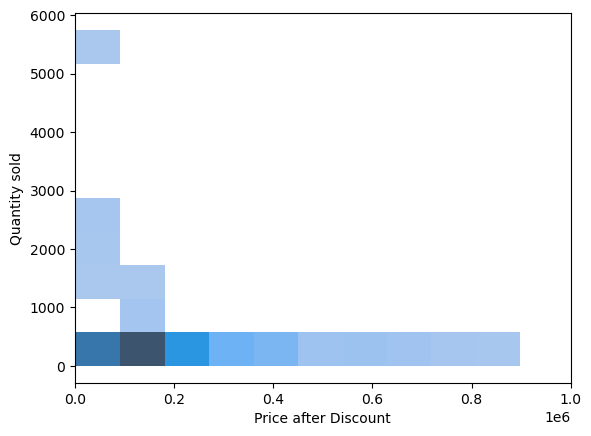

In [19]:
# Function plot category from Min sold -> Max sold By Price After Discount

ax = sns.histplot(pandaDf,x="PriceAfterDiscount",y="QuantitySold", kde=True, bins=10)
ax.set_xlim(0, 1000000)
ax.set_xlabel("Price after Discount")
ax.set_ylabel("Quantity sold")

In [20]:
#Util: Wrap text
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [21]:
# Top n san pham ban chay theo ten

def showTopNFromDfByQuantity(n, dataframe):
    topNDf = dataframe.orderBy(col('QuantitySold').desc())
    return topNDf

C:\Users\tuan1\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


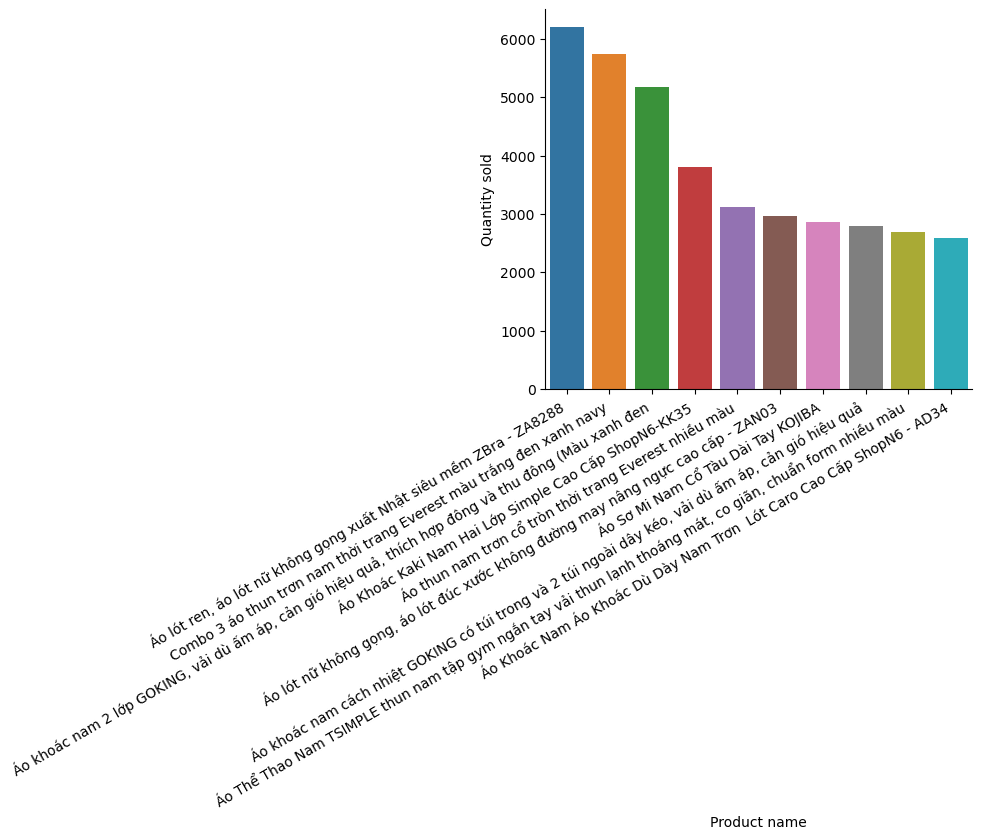

In [22]:
topNDf = showTopNFromDfByQuantity(10, aoDf).toPandas().head(10)
ax = sns.catplot(data=topNDf, x="ProductName", y="QuantitySold", kind="bar", margin_titles=True)
ax.set_xlabels("Product name")
ax.set_ylabels("Quantity sold")
fig = plt.gcf()
fig.autofmt_xdate()

In [24]:
# Sort by review rating
def showTopNFromDfByReview(n, minReviewCount, dataframe):
    topNDf = dataframe.filter(col('ReviewCount') > minReviewCount).orderBy(col('RatingAverage').desc())
    return topNDf

C:\Users\tuan1\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


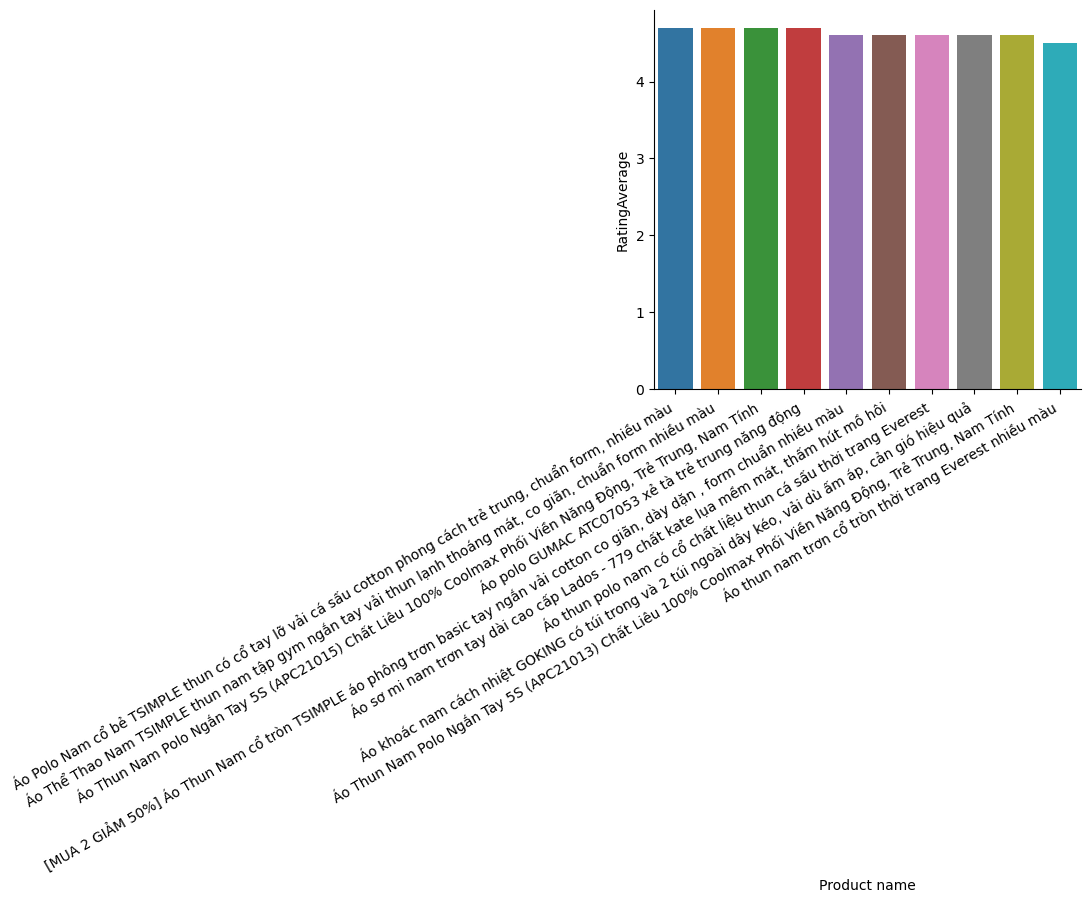

In [25]:
topNDf = showTopNFromDfByReview(10, 500, aoDf).toPandas().head(10)
ax = sns.catplot(data=topNDf, x="ProductName", y="RatingAverage", kind="bar", margin_titles=True)
ax.set_xlabels("Product name")
ax.set_ylabels("RatingAverage")
fig = plt.gcf()
fig.autofmt_xdate()